# Simulations

This notebook introduces the simulations used in this project.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof.sim import gen_power_spectrum

from neurodsp.sim import sim_powerlaw, sim_oscillation, sim_synaptic_current, sim_combined
from neurodsp.utils import create_times, set_random_seed
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts import plot_time_series, plot_power_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))
from apm.core.db import APMDB
from apm.plts.data import plot_timeseries_and_psd
from apm.plts.psd import custom_psd_style

In [3]:
# Set plot style
import seaborn as sns
sns.set_context('talk')

## Settings

First, we will define some settings for the simulations.

In [4]:
# Set random seed
set_random_seed(111)

In [5]:
# General simulation Settings
n_seconds = 10
fs = 500

# Component parameters
default_exp = -1.0
default_freq = 10
f_range = (1, None)

In [6]:
# Collect together parameters for combined signals
comps_osc = {'sim_powerlaw' : {'exponent' : default_exp},
             'sim_oscillation' : {'freq' : default_freq}}
comps_burst = {'sim_powerlaw' : {'exponent' : default_exp},
               'sim_bursty_oscillation' : {'freq' : default_freq}}

In [7]:
# Create a times vector for time series
times = create_times(n_seconds, fs)

In [8]:
# Plot settings
labels = {'xlabel' : '', 'ylabel' : ''}
tskwargs = {**labels, 'xlim' : [0, times[-1]]}

In [9]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FP = APMDB().figs_path + '/sims/'

## Time Series Simulations

Time series are simulated using [NeuroDSP](https://neurodsp-tools.github.io/). 

### Powerlaw Signal

First, we can simulate a 'powerlaw' signal, a 1/f signal that follow a powerlaw in the frequency domain. 

In [10]:
# Simulate a powerlaw signal
sig_pow = sim_powerlaw(n_seconds, fs, default_exp, f_range=f_range)

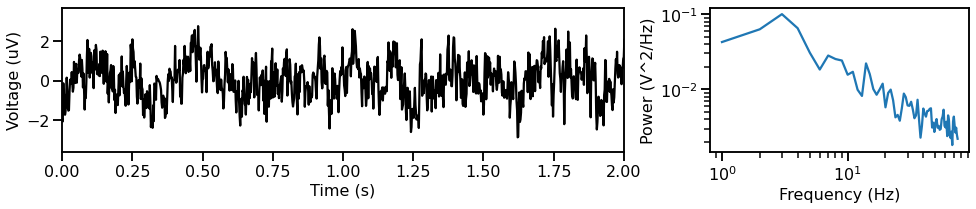

In [11]:
plot_timeseries_and_psd(times, sig_pow, fs)

### Continuous Oscillation

Next, we can simulate an  oscillation, in this case, a continuous sinusoid.

In [12]:
# Simulate an oscillation
sig_osc = sim_oscillation(n_seconds, fs, freq=default_freq)

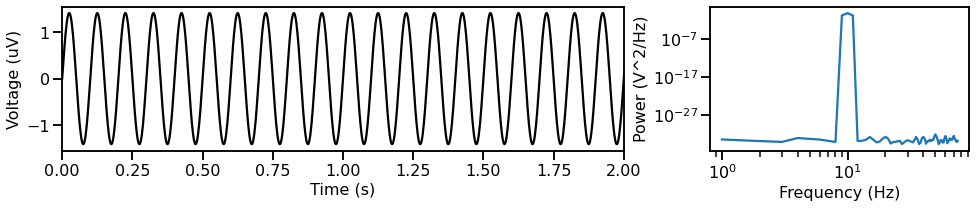

In [13]:
plot_timeseries_and_psd(times, sig_osc, fs)

### Combined Signal

Now we can can combine the aperiodic and periodic components from above, and create a combined signal.

In [14]:
# Simulate a combined signal, with an aperiodic and a periodic component
sig_comb = sim_combined(n_seconds, fs, comps_osc)

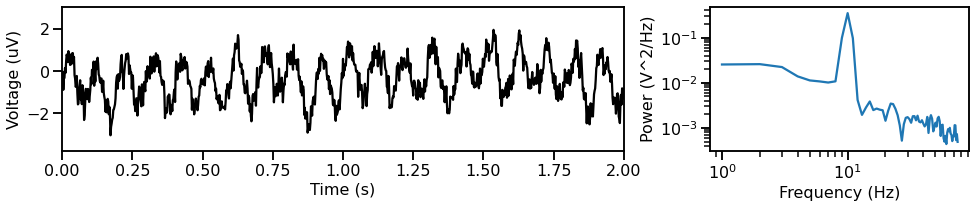

In [15]:
plot_timeseries_and_psd(times, sig_comb, fs)

### Synpatic Signal: Aperiodic Activity with a Knee

There are different possible ways to simulate aperiodic activity.

In this next simulation, we will simulate a 'synpatic current' model, which creates aperiodic activity with a knee.

In [16]:
# Simulate aperiodic activity from a synaptic current model
sig_kn = sim_synaptic_current(n_seconds, fs)

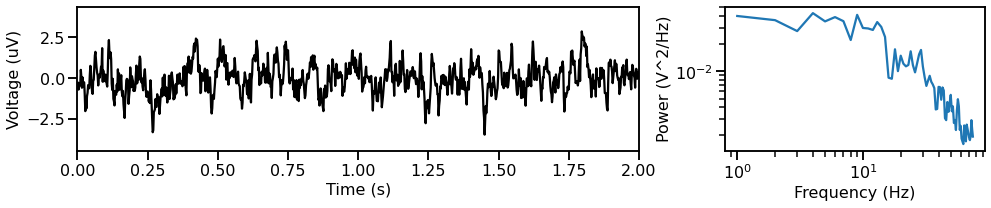

In [17]:
plot_timeseries_and_psd(times, sig_kn, fs)

### Bursty Oscillation

Oscillations are also not necessarily continuous. We we will simulate a combined signal with a bursty oscillation.

In [18]:
# Simulate a combined signal with a bursty oscillation
sig_burst = sim_combined(n_seconds, fs, comps_burst)

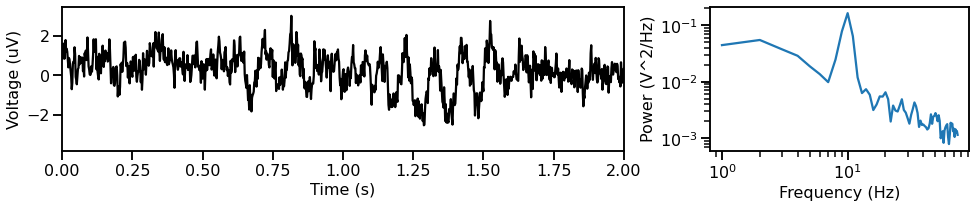

In [19]:
plot_timeseries_and_psd(times, sig_burst, fs)

## Example Time Series

In the notebooks that follow, you will see that measures are applied to a set of 'example' time series. 

These examples are time series that have been pre-computed, using the functions above. 

This set of example signals is shown here.

In [20]:
# Import the pre-computed example signals
from apm.sim.examples import TIMES, SIG_AP, SIG_KN, SIG_OSC, SIG_COMB, SIG_BURST

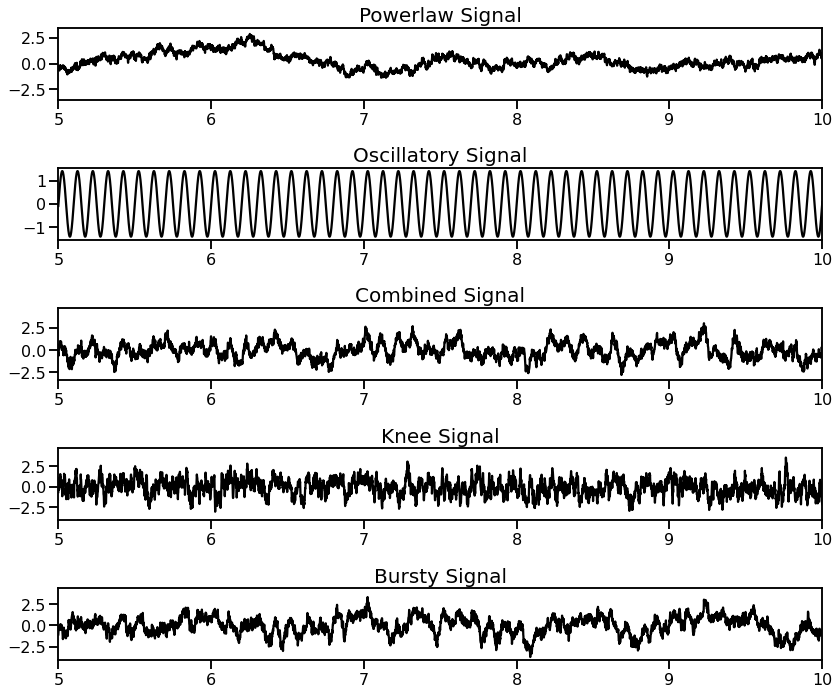

In [21]:
_, axes = plt.subplots(5, 1, figsize=(12, 10))
plt_kwargs = {'xlabel' : '', 'ylabel' : '', 'xlim' : [5, 10]}
plot_time_series(TIMES, SIG_AP, title='Powerlaw Signal', **plt_kwargs, ax=axes[0])
plot_time_series(TIMES, SIG_OSC, title='Oscillatory Signal', **plt_kwargs, ax=axes[1])
plot_time_series(TIMES, SIG_COMB, title='Combined Signal', **plt_kwargs, ax=axes[2])
plot_time_series(TIMES, SIG_KN, title='Knee Signal', **plt_kwargs, ax=axes[3])
plot_time_series(TIMES, SIG_BURST, title='Bursty Signal', **plt_kwargs, ax=axes[4])

## Power Spectrum Simulations

Power spectra are simulated using [SpecParam](https://fooof-tools.github.io/). 

### Single Peak & Fixed Mode

First, we can simulate a power spectrum with a single peak with a 1/f aperiodic component. 

In [22]:
freqs, powers = gen_power_spectrum([3, 40], [1, 1], [10, 0.3, 1], nlv=0.025)

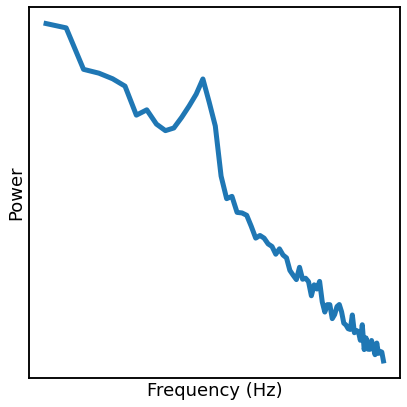

In [23]:
plot_power_spectra(freqs, powers, lw=5, ylabel='Power', custom_styler=custom_psd_style,
                   save_fig=SAVE_FIG, file_name='psd_fixed' + EXT, file_path=FP)

### Multi-Peak & Knee Mode

Next, we can simulate a pwoer spectrum that has multiple peaks, and an aperiodic component with a knee.

In [24]:
freqs, powers = gen_power_spectrum([1, 75], [0, 400, 1], [[5, 0.025, 1], [30, 0.02, 4]], nlv=0.001)

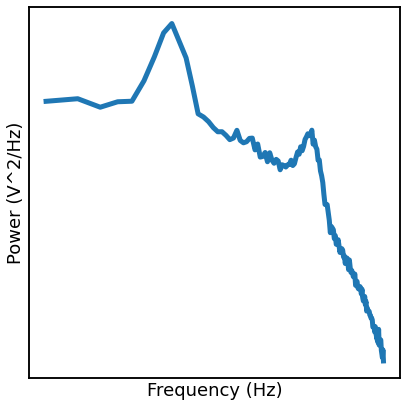

In [25]:
plot_power_spectra(freqs, powers, lw=5, custom_styler=custom_psd_style,
                   save_fig=SAVE_FIG, file_name='psd_knee' + EXT, file_path=FP)

### Simulating Power Law Signals through Spectral Rotation

The aperiodic components of the above time series simulations are created by spectrally rotating white noise. 

This section demonstrates how those simulations work. 

In [26]:
# Simulate a white noise signal
sig = sim_powerlaw(n_seconds, fs, exponent=0)

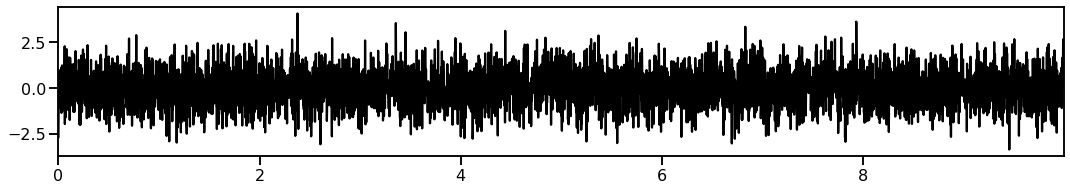

In [27]:
plot_time_series(times, sig, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='rot_ts_pre' + EXT, file_path=FP)

In [28]:
# Compute the power spectrum of the signal
freqs, pows = compute_spectrum(sig, fs, nperseg=250, noverlap=100)

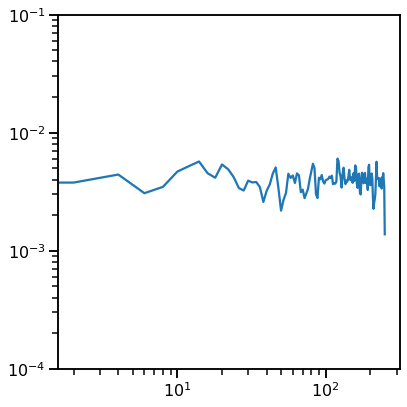

In [29]:
# Plot the power spectrum of the white noise signal
plot_power_spectra(freqs, pows, **labels, ylim=[0.0001, 0.1], 
                   save_fig=SAVE_FIG, file_name='rot_psd_pre' + EXT, file_path=FP)

In [30]:
# Rotate the spectrum to desired aperiodic exponent
pows_rot = rotate_powerlaw(freqs, pows, 1, f_rotation=100)

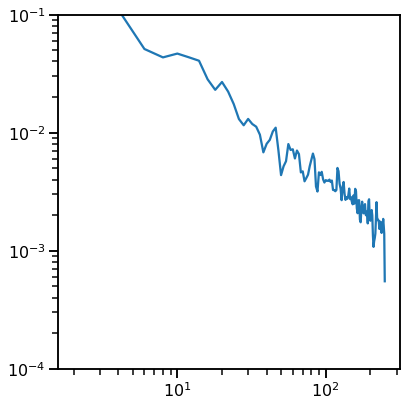

In [31]:
# Plot the power spectrum of the rotated signal
plot_power_spectra(freqs, pows_rot, **labels, ylim=[0.0001, 0.1], 
                   save_fig=SAVE_FIG, file_name='rot_psd_post' + EXT, file_path=FP)

In [32]:
# Get the rotated signal, back in the time domain
#   Note: this step directly uses the NDSP function, which rotates a new signal behind the scenes
sig = sim_powerlaw(n_seconds, fs, exponent=-1)

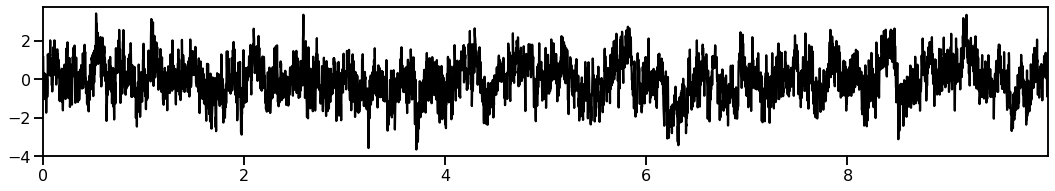

In [33]:
# Plot the time series of the rotated signal, with the desired aperiodic exponent
plot_time_series(times, sig, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='rot_ts_post' + EXT, file_path=FP)